# A5: Extension Analysis

##### Motivation/problem statement

The syndemic of COVID-19 and deaths from drug overdose in the US continues to evolve. Even though the number of COVID-19 deaths cases and deaths have trended downward since the peak in December 2020, this might not hold for drug abuse and overdose. Macroenvironmental changes that began during the COVID-19 pandemic, such as increased physical isolation, mental health stressors and economic insecurity, persist and may be associated with the continuing drug overdose cases.

The main question that will be explored for this project is as follows:
How did the COVID-19 pandemic affect drug overdose cases between February 1, 2020 through October 15, 2021, in Philadelphia, Pennsylvania. 

One of the main reasons I chose to analyze drug use/overdose related data is because it has a spreading impact on the people around the person that overdoses and suffers. According to the CDC, the total "economic burden" of opioid misuse alone in the United States is $78.5 billion a year, including the costs of healthcare, lost productivity, addiction treatment, and criminal justice involvement. This impact is huge and affects everyone in the economy. The sheer economic and financial impact is what makes this problem and analysis interesting.

<img src="https://cdn2.hubspot.net/hub/413387/file-2281849717.jpg?width=1800&name=file-2281849717.jpg" alt="drawing" width="400"/>

##### Research questions and/or hypotheses
Based on some preliminary research and analysis of the available dataset, I have formed the following hypotheses:

1. The number of drug overdoses cases during the COVID-19 pandemic is significantly higher than before the start of the pandemic
2. The age does not affect the dosage of Naloxone administered
3. The drug type does not affect the dosage of Naloxone administered


For the above mentioned hypotheses we make the following assumptions:
* We define the pandemic period to be between: February 1, 2020 - October 15, 2021
* We only analyze data from Philadelphia, Pennsylvania



In [1]:
import os
import datetime

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (FuncFormatter)

import scipy.stats as stats

from pprint import pprint as pp
from tqdm import tqdm

In [2]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'
ERROR_DATA_PATH = '../data/errors'

for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, ERROR_DATA_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
DRUG_OVERDOSE_FILE = os.path.join(PROCESSED_DATA_PATH, 'Pennsylvania-Drug-Overdose.csv')
COVID_DATA_FILE = os.path.join(PROCESSED_DATA_PATH, 'Philadelphia-Pennsylvania-Covid-Data.csv')
PHILLY_POPULATION_DATA_FILE = os.path.join(PROCESSED_DATA_PATH, 'Philadelphia-Ages.csv')

In [4]:
# We define the start of the pandemic to be: February 1, 2020
COVID_START_PERIOD = datetime.date(2020, 2, 1)

## Parsing Overdose Cases File

This data has been obtained from [OpenDATAPA](https://data.pa.gov/Opioid-Related/Overdose-Information-Network-Data-CY-January-2018-/hbkk-dwy3)

This dataset contains summary information on overdose responses and naloxone administrations by Pennsylvania criminal justice agencies and some third-party (i.e. EMS, Fire, Medical Staff, etc) first responders voluntarily entering incident data. Due to the voluntary nature of the application, the ODIN information provided may not represent the totality of all overdose and/or naloxone administration incidents involving criminal justice agencies occurring within the Commonwealth. Although this dataset does include some third-party administrations of naloxone, it should not be used to measure overdose response and naloxone administration incidents among all first responders.

In [5]:
overdose_df = pd.read_csv(
    os.path.join(DRUG_OVERDOSE_FILE), 
    low_memory=False,
    header=[0]
)

# Parse the date col as the correct type
overdose_df['Incident Date'] = pd.to_datetime(overdose_df['Incident Date']).dt.date 
overdose_df['Incident Year'] = pd.to_datetime(overdose_df['Incident Date']).dt.year
overdose_df['Incident Month'] = pd.to_datetime(overdose_df['Incident Date']).dt.month

overdose_pen_df = overdose_df.loc[(overdose_df['Incident County Name'] == 'Philadelphia')]
overdose_pen_df['Overdose Case'] = 1
overdose_pen_df['Total Dosage(mg)'] = overdose_pen_df['Dose Count'] * overdose_pen_df['Dose Unit']

<ipython-input-5-9f60e585aca7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overdose_pen_df['Overdose Case'] = 1
<ipython-input-5-9f60e585aca7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overdose_pen_df['Total Dosage(mg)'] = overdose_pen_df['Dose Count'] * overdose_pen_df['Dose Unit']


In [6]:
overdose_pen_df.head()

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Victim State,Victim County,Accidental Exposure,Victim OD Drug ID,Susp OD Drug Desc,Naloxone Administered,Administration ID,Dose Count,Dose Unit,Dose Desc,Response Time Desc,Survive,Response Desc,Revive Action Desc,Third Party Admin Desc,Incident County FIPS Code,Incident County Latitude,Incident County Longitude,Victim County FIPS Code,Victim County Latitude,Victim County Longitude,Incident County Latitude and Longitude,Victim County Latitude and Longitude,Incident Year,Incident Month,Overdose Case,Total Dosage(mg)
89,19329,2020-09-17,21:30:00,Thursday,Philadelphia,Pennsylvania,15323,Female,30 - 39,White,Not Hispanic,Pennsylvania,Philadelphia,N,21093,OTHER,Y,10524,1,2,MG,<1 MINUTE,Y,RESPONSIVE AND ALERT,HOSPITAL CONSCIOUS,NaN,101,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020,9,1,2
190,20441,2020-11-07,19:00:00,Saturday,Philadelphia,Pennsylvania,16143,Male,30 - 39,Black,Not Hispanic,NaN,NaN,N,22338,OTHER,N,0,0,0,NaN,>5 MINUTES,Y,COMBATIVE,TRANSPORTED TO TREATMENT,NaN,101,40.004444,-75.140236,NaN,0.000000,0.000000,"(40.004444, -75.140236)","(0.0, 0.0)",2020,11,1,0
203,20441,2020-11-07,19:00:00,Saturday,Philadelphia,Pennsylvania,16143,Male,30 - 39,Black,Not Hispanic,NaN,NaN,N,22337,HEROIN,N,0,0,0,NaN,>5 MINUTES,Y,COMBATIVE,TRANSPORTED TO TREATMENT,NaN,101,40.004444,-75.140236,NaN,0.000000,0.000000,"(40.004444, -75.140236)","(0.0, 0.0)",2020,11,1,0
599,19881,2020-10-14,0:00:00,Wednesday,Philadelphia,Pennsylvania,15715,Male,40 - 49,White,Not Hispanic,Pennsylvania,Chester,N,21707,HEROIN,N,0,0,0,NaN,NaN,Y,NaN,NaN,NaN,101,40.004444,-75.140236,29.0,39.974871,-75.756265,"(40.004444, -75.140236)","(39.974871, -75.756265)",2020,10,1,0
701,518,2018-02-19,0:45:00,Monday,Philadelphia,Pennsylvania,402,Male,50 - 59,Black,Unknown,Pennsylvania,Philadelphia,N,566,HEROIN,Y,265,2,4,MG,DON'T KNOW,Y,RESPONSIVE AND ANGRY,HOSPITAL CONSCIOUS,NaN,101,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2018,2,1,8


In [7]:
overdose_pen_precovid_df = overdose_pen_df.loc[(overdose_pen_df['Incident Date'] < COVID_START_PERIOD)]
overdose_pen_precovid_monthly_df = overdose_pen_precovid_df.groupby(
    ['Incident Year', 'Incident Month']
).agg({'Overdose Case':'sum'}).reset_index()

In [8]:
overdose_pen_duringcovid_df = overdose_pen_df.loc[
    (overdose_pen_df['Incident Date'] >= COVID_START_PERIOD)
]
overdose_pen_duringcovid_monthly_df = overdose_pen_duringcovid_df.groupby(
    ['Incident Year', 'Incident Month']
).agg({'Overdose Case':'sum'}).reset_index()

## Parsing COVID Cases File

This file was produced in `A4-Common-Analysis.ipynb` - Check this notebook for details 

In [9]:
cases_df = pd.read_csv(
    COVID_DATA_FILE, 
    low_memory=False,
    header=[0]
)

# Parse the date col as the correct type
cases_df['Date'] = pd.to_datetime(cases_df['Date']).dt.date
cases_df['Year'] = pd.to_datetime(cases_df['Date']).dt.year
cases_df['Month'] = pd.to_datetime(cases_df['Date']).dt.month

In [10]:
cases_df.head()

,Date,Initial Population,Susceptible Population,Cases,Cases Moving Average,Cases Cumulative,Rate of Cases,Rate of Daily Cases,Deaths,Deaths Moving Average,Deaths Cumulative,Rate of Infection,Rate of Daily Infection,Year,Month
0,2020-02-01,1603797,1603797.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,2020,2
1,2020-02-02,1603797,1603797.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,2020,2
2,2020-02-03,1603797,1603797.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,2020,2
3,2020-02-04,1603797,1603797.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,2020,2
4,2020-02-05,1603797,1603797.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,2020,2


## Research Question 1

We first attempt answer the following question:

**The number of drug overdoses cases during the COVID-19 pandemic is significantly higher than before the start of the pandemic**

This question will be answered using the following methodology:

1. Create a visualization of the time-series data
2. Run a t-test to check hypothesis

In [11]:
case_counts = pd.merge(overdose_pen_df, cases_df, how='right', left_on='Incident Date', right_on='Date')
case_counts.sort_values(by='Incident Date', inplace=True)
case_counts

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Victim State,Victim County,Accidental Exposure,Victim OD Drug ID,Susp OD Drug Desc,Naloxone Administered,Administration ID,Dose Count,Dose Unit,Dose Desc,Response Time Desc,Survive,Response Desc,Revive Action Desc,Third Party Admin Desc,Incident County FIPS Code,Incident County Latitude,Incident County Longitude,Victim County FIPS Code,Victim County Latitude,Victim County Longitude,Incident County Latitude and Longitude,Victim County Latitude and Longitude,Incident Year,Incident Month,Overdose Case,Total Dosage(mg),Date,Initial Population,Susceptible Population,Cases,Cases Moving Average,Cases Cumulative,Rate of Cases,Rate of Daily Cases,Deaths,Deaths Moving Average,Deaths Cumulative,Rate of Infection,Rate of Daily Infection,Year,Month
10,14913.0,2020-02-11,21:13:00,Tuesday,Philadelphia,Pennsylvania,11927.0,Female,40 - 49,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16039.0,UNKNOWN,Y,8081.0,1.0,0.0,UNKNOWN,1-3 MINUTES,Y,RESPONSIVE BUT SEDATED,HOSPITAL CONSCIOUS,EMS,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,0.0,2020-02-11,1603797,1603797.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2020,2
17,14996.0,2020-02-18,18:30:00,Tuesday,Philadelphia,Pennsylvania,11998.0,Male,60 - 69,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16156.0,UNKNOWN,Y,8130.0,2.0,2.0,MG,3-5 MINUTES,Y,RESPONSIVE AND ALERT,REFUSED TRANSPORT,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,4.0,2020-02-18,1603797,1603797.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2020,2
18,14996.0,2020-02-18,18:30:00,Tuesday,Philadelphia,Pennsylvania,12000.0,Male,60 - 69,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16159.0,UNKNOWN,Y,8132.0,1.0,2.0,MG,3-5 MINUTES,U,NO RESPONSE TO NALOXONE,HOSPITAL UNCONSCIOUS,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,2.0,2020-02-18,1603797,1603797.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2020,2
32,15292.0,2020-03-03,18:20:00,Tuesday,Philadelphia,Pennsylvania,12223.0,Male,50 - 59,White,Unknown,Pennsylvania,Philadelphia,N,16508.0,UNKNOWN,Y,8302.0,2.0,4.0,MG,1-3 MINUTES,Y,NO RESPONSE TO NALOXONE,HOSPITAL CONSCIOUS,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,3.0,1.0,8.0,2020-03-03,1603797,1603797.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2020,3
36,15364.0,2020-03-07,11:49:00,Saturday,Philadelphia,Pennsylvania,12280.0,Male,30 - 39,White,Not Hispanic,Pennsylvania,Philadelphia,N,16594.0,FENTANYL,N,0.0,0.0,0.0,NaN,NaN,N,NaN,NaN,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,3.0,1.0,0.0,2020-03-07,1603797,1603797.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2020,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-09,1603797,1423108.0,0.0,270.0,176753.0,0.000000,-0.015962,0.0,3.0,3936.0,0.018973,0.000000,2021,10
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-10,1603797,1423108.0,0.0,270.0,176753.0,0.000000,0.000000,0.0,3.0,3936.0,0.018973,0.000000,2021,10
662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-11,

In [12]:
# Replace the categorical value with the numeric value
case_counts['Survive'].replace(
    {
        'Y': 1, 
        'U': 0,
        'N': 0,
        np.nan: 0
    }, 
    inplace=True
)

In [13]:
case_counts_date = case_counts.groupby(['Year', 'Month']).agg({'Cases': 'sum', 'Overdose Case': 'sum'}).reset_index()
case_counts_date['Day'] = 1
case_counts_date['Date'] = pd.to_datetime(case_counts_date[['Year', 'Month', 'Day']])
case_counts_date

,Year,Month,Cases,Overdose Case,Day,Date
0,2020,2,0.0,3.0,1,2020-02-01
1,2020,3,1315.0,5.0,1,2020-03-01
2,2020,4,13697.0,5.0,1,2020-04-01
3,2020,5,8336.0,3.0,1,2020-05-01
4,2020,6,3884.0,14.0,1,2020-06-01
5,2020,7,4365.0,6.0,1,2020-07-01
6,2020,8,4100.0,13.0,1,2020-08-01
7,2020,9,3615.0,4.0,1,2020-09-01
8,2020,10,7279.0,2.0,1,2020-10-01
9,2020,11,22778.0,6.0,1,2020-11-01


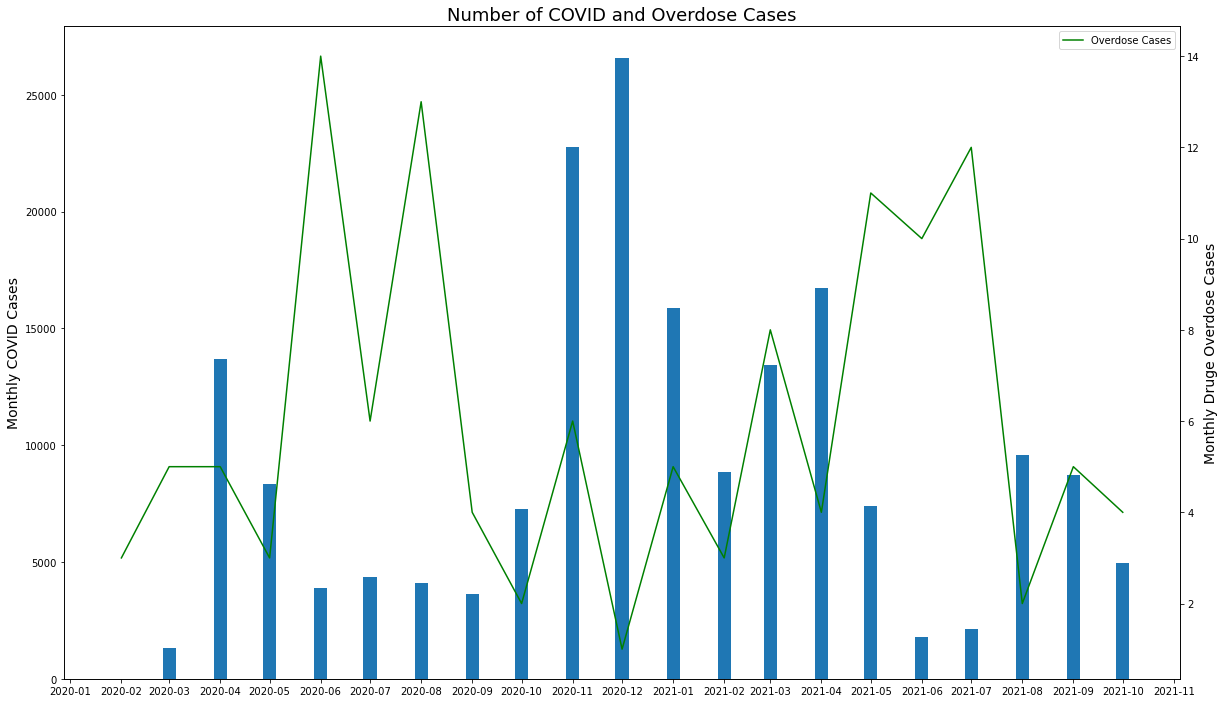

In [14]:
plt.figure(figsize=(20,12))
# plt.style.use('seaborn-darkgrid')
plt.style.use('default')

ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.bar('Date', 'Cases', data=case_counts_date, width=8)
ax2.plot('Date', 'Overdose Case', 'g', data=case_counts_date, label='Overdose Cases')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)

# # Add title and axis names
plt.title(f'Number of COVID and Overdose Cases', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Monthly COVID Cases', fontsize=14)
ax2.set_ylabel('Monthly Druge Overdose Cases', fontsize=14)

# ax.grid()
ax2.legend()

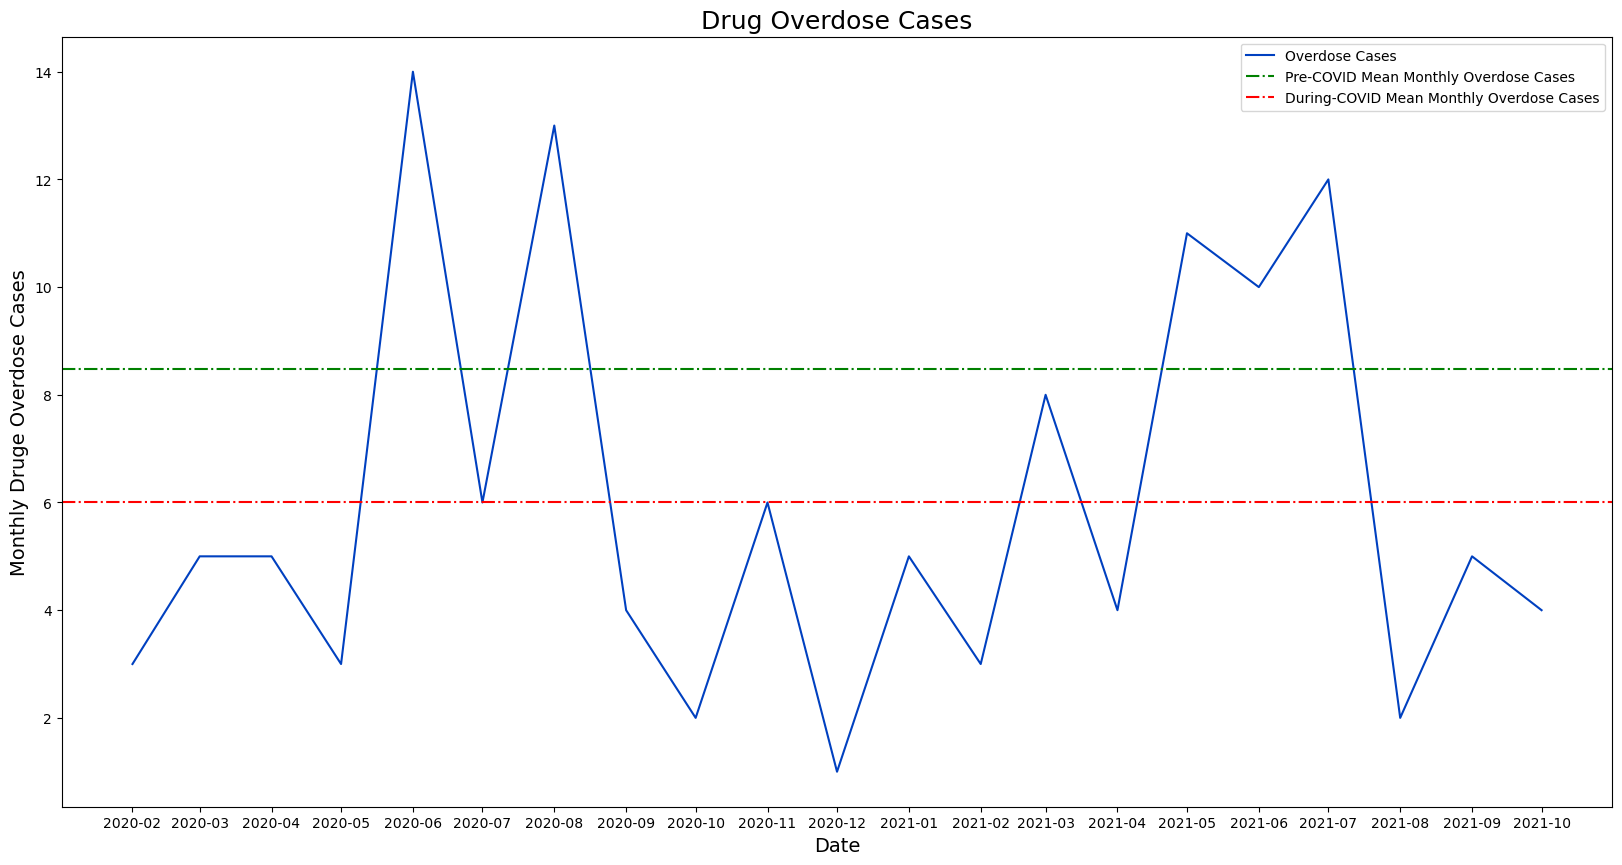

In [15]:
plt.figure(figsize=(20,10))
ax = plt.gca()
# ax2 = ax.twinx()

# Create lines and choose characteristics
# ax.bar('Date', 'Cases', data=case_counts_date, width=8)
ax.plot('Date', 'Overdose Case', '#0040C0', data=case_counts_date, label='Overdose Cases')

ax.axhline(y=overdose_pen_precovid_monthly_df['Overdose Case'].mean(), color='g', linestyle='dashdot', label='Pre-COVID Mean Monthly Overdose Cases')
ax.axhline(y=overdose_pen_duringcovid_monthly_df['Overdose Case'].mean(), color='r', linestyle='dashdot', label='During-COVID Mean Monthly Overdose Cases')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# # Add title and axis names
plt.title(f'Drug Overdose Cases', fontsize=18)
plt.xlabel('Date', fontsize=14)
# ax.set_ylabel('Monthly COVID Cases', fontsize=14)
ax.set_ylabel('Monthly Druge Overdose Cases', fontsize=14)

#ax.grid()
ax.legend()

In [16]:
pre_coivd_overdose_cases = list(overdose_pen_precovid_monthly_df['Overdose Case'])
during_coivd_overdose_cases = list(overdose_pen_duringcovid_monthly_df['Overdose Case'])
print(pre_coivd_overdose_cases, during_coivd_overdose_cases)

[3, 8, 5, 8, 3, 7, 17, 19, 16, 7, 3, 9, 13, 3, 7, 9, 7, 7, 13, 11, 16, 7, 4, 3, 7] [3, 5, 5, 3, 14, 6, 13, 4, 2, 6, 1, 5, 3, 8, 4, 11, 10, 12, 2, 5, 4]


In [17]:
tvalue, pvalue = stats.ttest_ind(pre_coivd_overdose_cases, during_coivd_overdose_cases)
print(f'The fvalue is: {tvalue:.4} and the p value is: {pvalue:.4}')

The fvalue is: 1.922 and the p value is: 0.06112


## Research Question 2

We first attempt answer the following question:

**The age does not affect the dosage of Naloxone administered**

This question will be answered using the following methodology:

1. We will pivot the table to make the age range the columns and the rows will be the dosage of Naloxone administered for each case that has been reported. 
2. We then run an ANNOVA test with the age ranges with the following hypotheses:
    
    * H_0: There is no difference between Naloxone dosage administered between the ages
    * H_1: There is a difference between Naloxone dosage administered between the ages

In [18]:
case_counts.head()

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Victim State,Victim County,Accidental Exposure,Victim OD Drug ID,Susp OD Drug Desc,Naloxone Administered,Administration ID,Dose Count,Dose Unit,Dose Desc,Response Time Desc,Survive,Response Desc,Revive Action Desc,Third Party Admin Desc,Incident County FIPS Code,Incident County Latitude,Incident County Longitude,Victim County FIPS Code,Victim County Latitude,Victim County Longitude,Incident County Latitude and Longitude,Victim County Latitude and Longitude,Incident Year,Incident Month,Overdose Case,Total Dosage(mg),Date,Initial Population,Susceptible Population,Cases,Cases Moving Average,Cases Cumulative,Rate of Cases,Rate of Daily Cases,Deaths,Deaths Moving Average,Deaths Cumulative,Rate of Infection,Rate of Daily Infection,Year,Month
10,14913.0,2020-02-11,21:13:00,Tuesday,Philadelphia,Pennsylvania,11927.0,Female,40 - 49,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16039.0,UNKNOWN,Y,8081.0,1.0,0.0,UNKNOWN,1-3 MINUTES,1,RESPONSIVE BUT SEDATED,HOSPITAL CONSCIOUS,EMS,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,0.0,2020-02-11,1603797,1603797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,2
17,14996.0,2020-02-18,18:30:00,Tuesday,Philadelphia,Pennsylvania,11998.0,Male,60 - 69,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16156.0,UNKNOWN,Y,8130.0,2.0,2.0,MG,3-5 MINUTES,1,RESPONSIVE AND ALERT,REFUSED TRANSPORT,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,4.0,2020-02-18,1603797,1603797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,2
18,14996.0,2020-02-18,18:30:00,Tuesday,Philadelphia,Pennsylvania,12000.0,Male,60 - 69,Black,Not Hispanic,Pennsylvania,Philadelphia,N,16159.0,UNKNOWN,Y,8132.0,1.0,2.0,MG,3-5 MINUTES,0,NO RESPONSE TO NALOXONE,HOSPITAL UNCONSCIOUS,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,2.0,1.0,2.0,2020-02-18,1603797,1603797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,2
32,15292.0,2020-03-03,18:20:00,Tuesday,Philadelphia,Pennsylvania,12223.0,Male,50 - 59,White,Unknown,Pennsylvania,Philadelphia,N,16508.0,UNKNOWN,Y,8302.0,2.0,4.0,MG,1-3 MINUTES,1,NO RESPONSE TO NALOXONE,HOSPITAL CONSCIOUS,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,3.0,1.0,8.0,2020-03-03,1603797,1603797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,3
36,15364.0,2020-03-07,11:49:00,Saturday,Philadelphia,Pennsylvania,12280.0,Male,30 - 39,White,Not Hispanic,Pennsylvania,Philadelphia,N,16594.0,FENTANYL,N,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,101.0,40.004444,-75.140236,101.0,40.004444,-75.140236,"(40.004444, -75.140236)","(40.004444, -75.140236)",2020.0,3.0,1.0,0.0,2020-03-07,1603797,1603797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,3


In [19]:
drug_overdose_pop_df = pd.merge(case_counts.groupby('Age Range').agg({'Overdose Case': 'sum', 
                                                                      'Survive': 'sum',
                                                                      'Total Dosage(mg)': 'mean'
                                                                     }).reset_index(), 
                       pd.read_csv(PHILLY_POPULATION_DATA_FILE), 
                       how='inner', 
                       on='Age Range')
drug_overdose_pop_df['Survival Rate'] = drug_overdose_pop_df['Survive'] / drug_overdose_pop_df['Overdose Case']
drug_overdose_pop_df

,Age Range,Overdose Case,Survive,Total Dosage(mg),Population,Survival Rate
0,0 - 9,2.0,0,0.000000,210272,0.000000
1,15 - 19,3.0,3,4.000000,110701,1.000000
2,20 - 24,3.0,0,8.000000,117609,0.000000
3,25 - 29,15.0,15,6.000000,112432,1.000000
4,30 - 39,43.0,40,4.279070,222387,0.930233
5,40 - 49,35.0,31,5.142857,201220,0.885714
6,50 - 59,20.0,15,4.200000,158545,0.750000
7,60 - 69,4.0,3,5.500000,111460,0.750000
8,80 - *,1.0,0,0.000000,67006,0.000000


In [20]:
overdose_dosage_pivot_df = case_counts.pivot(columns='Age Range', values='Total Dosage(mg)')
overdose_dosage_pivot_df.dropna(how='all', inplace=True)

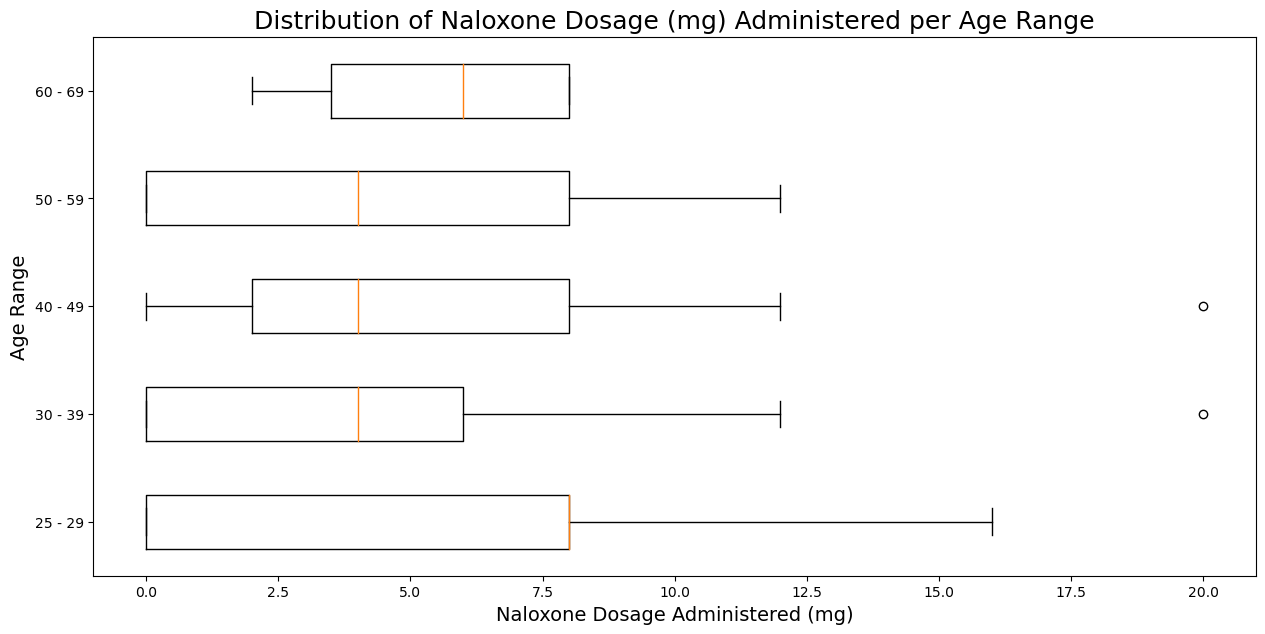

In [21]:
columns = [
                list(overdose_dosage_pivot_df['25 - 29'].dropna()),
                list(overdose_dosage_pivot_df['30 - 39'].dropna()),
                list(overdose_dosage_pivot_df['40 - 49'].dropna()),
                list(overdose_dosage_pivot_df['50 - 59'].dropna()),
                list(overdose_dosage_pivot_df['60 - 69'].dropna())
          ]


plt.figure(figsize=(15,7))
ax = plt.gca()

ax.boxplot(columns, vert=0)
plt.yticks([1, 2, 3, 4, 5], ['25 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69'])

plt.title(f'Distribution of Naloxone Dosage (mg) Administered per Age Range', fontsize=18)
plt.xlabel('Naloxone Dosage Administered (mg)', fontsize=14)
ax.set_ylabel('Age Range', fontsize=14)

plt.show()

In [22]:
fvalue, pvalue = stats.f_oneway(
                list(overdose_dosage_pivot_df['25 - 29'].dropna()),
                list(overdose_dosage_pivot_df['30 - 39'].dropna()),
                list(overdose_dosage_pivot_df['40 - 49'].dropna()),
                list(overdose_dosage_pivot_df['50 - 59'].dropna()),
                list(overdose_dosage_pivot_df['60 - 69'].dropna())
)

In [23]:
print(f'The fvalue is: {fvalue:.4} and the p value is: {pvalue:.4}')

The fvalue is: 0.5671 and the p value is: 0.6871


## Research Question 3

We first attempt answer the following question:

**The drug type does not affect the dosage of Naloxone administered**

This question will be answered using the following methodology:

1. We will pivot the table to make the drug type the columns and the rows will be the dosage of Naloxone administered for each case that has been reported. 
2. We then run an ANNOVA test with the age ranges with the following hypotheses:
    
    * H_0: There is no difference between Naloxone dosage administered between the drug type
    * H_1: There is a difference between Naloxone dosage administered between the drug type

In [24]:
drug_overdose_desc_df = case_counts.groupby('Susp OD Drug Desc').agg({'Overdose Case': 'sum'}).reset_index().sort_values(by='Overdose Case', ascending=False)
drug_overdose_desc_df.head(10)

,Susp OD Drug Desc,Overdose Case
6,HEROIN,46.0
12,UNKNOWN,37.0
4,FENTANYL,16.0
0,ALCOHOL,5.0
8,OTHER,5.0
3,COCAINE/CRACK,4.0
5,FENTANYL ANALOG/OTHER SYNTHETIC OPIOID,4.0
9,PHARMACEUTICAL OPIOID,2.0
10,PHARMACEUTICAL OTHER,2.0
11,SYNTHETIC MARIJUANA,2.0


In [25]:
drug_overdose_desc_df = drug_overdose_desc_df[drug_overdose_desc_df['Susp OD Drug Desc'] != 0]
drug_overdose_desc_df['Susp OD Drug Desc'].unique()

array(['HEROIN', 'UNKNOWN', 'FENTANYL', 'ALCOHOL', 'OTHER',
       'COCAINE/CRACK', 'FENTANYL ANALOG/OTHER SYNTHETIC OPIOID',
       'PHARMACEUTICAL OPIOID', 'PHARMACEUTICAL OTHER',
       'SYNTHETIC MARIJUANA', 'BARBITURATES (I.E. AMYTAL, NEMBUTAL, ETC)',
       'BENZODIAZEPINES (I.E.VALIUM, XANAX, ATIVAN, ETC)', 'METHADONE'],
      dtype=object)

In [26]:
drug_overdose_desc_df['Susp OD Drug Desc'].replace(
    {
        'FENTANYL ANALOG/OTHER SYNTHETIC OPIOID': 'SYNTHETIC OPIOID',
        'SYNTHETIC MARIJUANA': 'MARIJUANA',
        'BARBITURATES (I.E. AMYTAL, NEMBUTAL, ETC)': 'BARBITURATES',
        'BENZODIAZEPINES (I.E.VALIUM, XANAX, ATIVAN, ETC)': 'BENZODIAZEPINES'
    }, inplace=True
)

Text(0, 0.5, 'Cumulative Number of Cases')

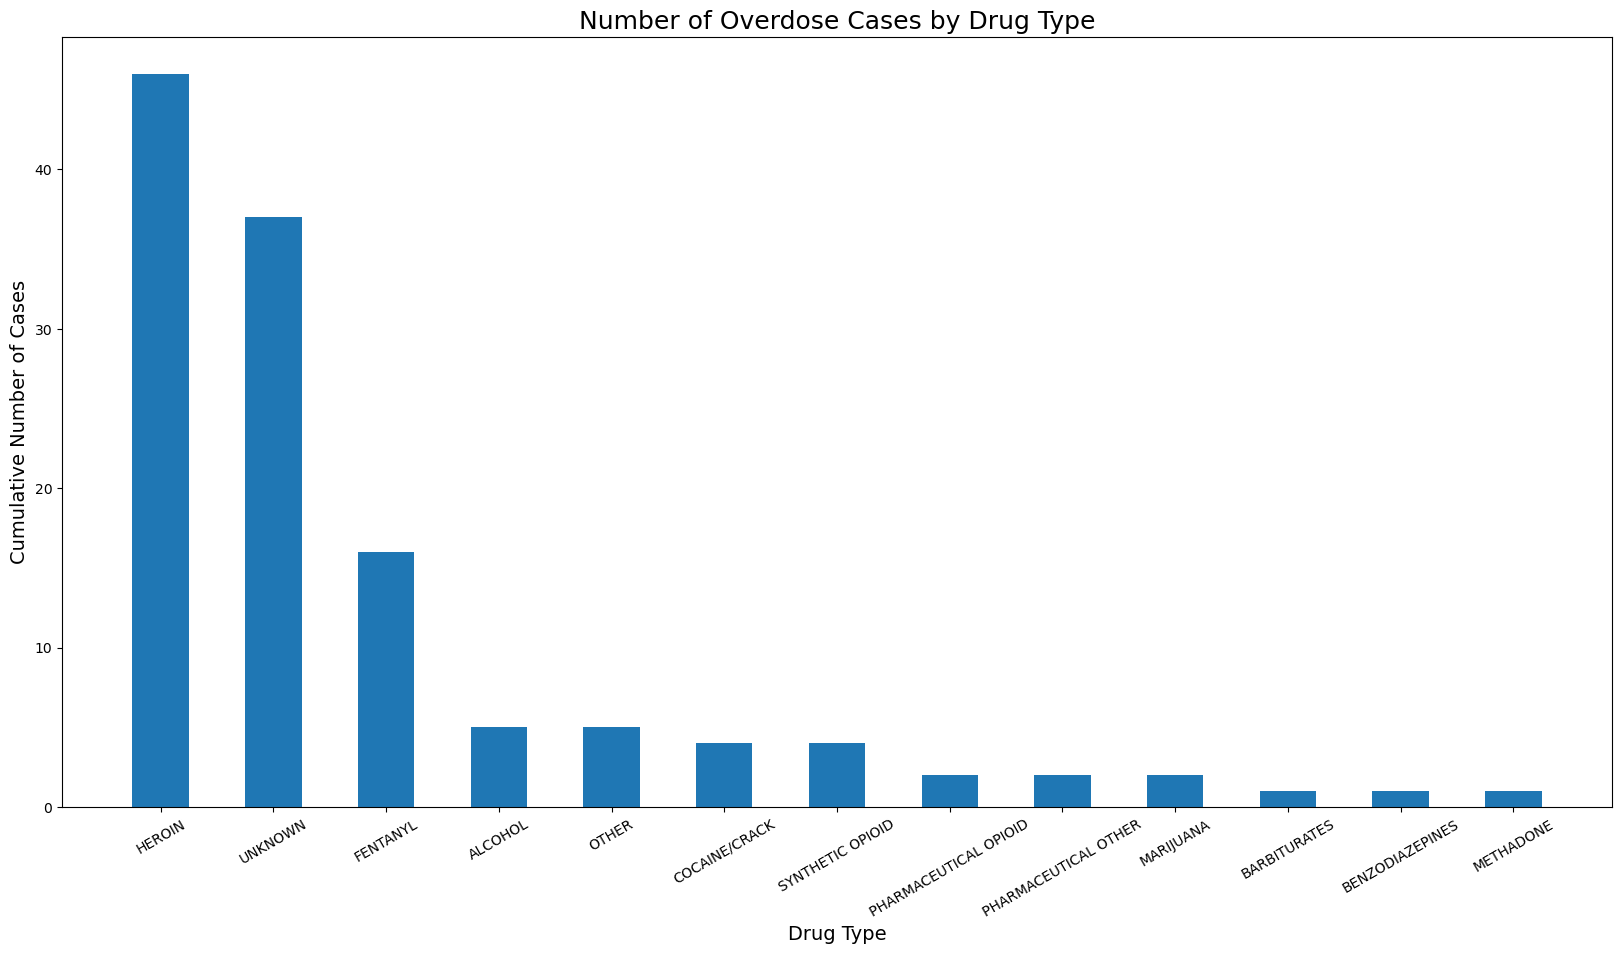

In [27]:
plt.figure(figsize=(20,10))
ax = plt.gca()

# Create lines and choose characteristics
ax.bar('Susp OD Drug Desc', 'Overdose Case', data=drug_overdose_desc_df, width=0.5)

# Add title and axis names
plt.title(f'Number of Overdose Cases by Drug Type', fontsize=18)

plt.xlabel('Drug Type', fontsize=14)
plt.xticks(rotation = 30)

ax.set_ylabel('Cumulative Number of Cases', fontsize=14)

In [28]:
overdose_dosage_pivot_drug_df = case_counts.pivot(columns='Susp OD Drug Desc', values='Total Dosage(mg)')
overdose_dosage_pivot_drug_df.dropna(how='all', inplace=True)
overdose_dosage_pivot_drug_df.head()

Susp OD Drug Desc,NaN,ALCOHOL,"BARBITURATES (I.E. AMYTAL, NEMBUTAL, ETC)","BENZODIAZEPINES (I.E.VALIUM, XANAX, ATIVAN, ETC)",COCAINE/CRACK,FENTANYL,FENTANYL ANALOG/OTHER SYNTHETIC OPIOID,HEROIN,METHADONE,OTHER,PHARMACEUTICAL OPIOID,PHARMACEUTICAL OTHER,SYNTHETIC MARIJUANA,UNKNOWN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
36,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


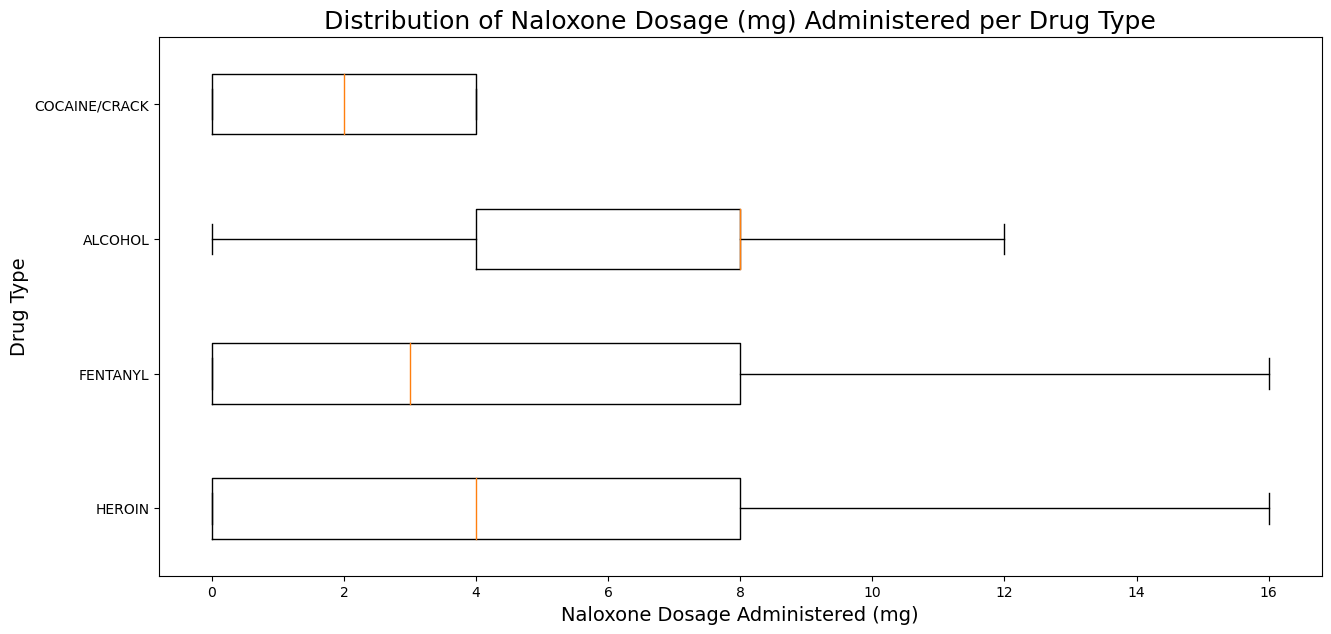

In [29]:
columns = [
                list(overdose_dosage_pivot_drug_df['HEROIN'].dropna()),
                list(overdose_dosage_pivot_drug_df['FENTANYL'].dropna()),
                list(overdose_dosage_pivot_drug_df['ALCOHOL'].dropna()),
                list(overdose_dosage_pivot_drug_df['COCAINE/CRACK'].dropna()),
          ]

plt.figure(figsize=(15,7))
ax = plt.gca()

ax.boxplot(columns, vert=0)
plt.yticks([1, 2, 3, 4], ['HEROIN', 'FENTANYL', 'ALCOHOL', 'COCAINE/CRACK'])

plt.title(f'Distribution of Naloxone Dosage (mg) Administered per Drug Type', fontsize=18)
plt.xlabel('Naloxone Dosage Administered (mg)', fontsize=14)
ax.set_ylabel('Drug Type', fontsize=14)

plt.show()

In [30]:
fvalue, pvalue = stats.f_oneway(
                list(overdose_dosage_pivot_drug_df['HEROIN'].dropna()),
                list(overdose_dosage_pivot_drug_df['FENTANYL'].dropna()),
                list(overdose_dosage_pivot_drug_df['ALCOHOL'].dropna()),
                list(overdose_dosage_pivot_drug_df['COCAINE/CRACK'].dropna()),
)

In [31]:
print(f'The fvalue is: {fvalue:.4} and the p value is: {pvalue:.4}')

The fvalue is: 0.8348 and the p value is: 0.4795
